In [1]:
# in this tutorial, we will build a PdZn binary alloys with random composition using CELL software, to do so differents steps are needed:
# I have added some questions for the training at the end

#step 1 is to build a parent cell which will be composed from the primitive cell here Pd and the substitute here Zn

%matplotlib inline 
from ase.build import fcc111, add_adsorbate # ASE's utilities to build the surface
from clusterx.parent_lattice import ParentLattice 
from clusterx.structures_set import StructuresSet
from clusterx.visualization import juview
from clusterx.super_cell import SuperCell
from ase import Atoms
from ase.build import surface
from random import randint
import numpy as np
np.random.seed(10)

from ase.build import molecule

# define primitive cell and supercell shape
scell_x, scell_y = 3, 3
layer_height = 4

'''
a = 2.889
c = 3.329


Alloy= Atoms('PdCu', scaled_positions=[(0, 0, 0),
                                (0.5, 0.5, 0),
                                ],
              cell=[a, a, c],
              pbc=True)

pri = surface(Alloy, (1, 1, 1), layer_height)
pri.center(vacuum=10, axis=2)
'''
pri = fcc111("Pd", (1,1,layer_height), a=3.939, vacuum=10)

juview(pri)

NGLWidget()

In [2]:
# before we start the subtitution it is recommended to know the index of the atoms
symbols = pri.get_chemical_symbols() # Get Chemical symbols of slab
z_coords = pri.get_positions()[:,2] # Get z-coordinate of atomic positions in slab

print("{0:<19s}|{1:<19s}|{2:<19s}".format("Atom index","Chemical symbol","z coordinate")) # Print headers
for i, (symbol, z_coord) in enumerate(zip(symbols,z_coords)):
    print("{0:<19d}|{1:<19s}|{2:<19.3f}".format(i,symbol,z_coord)) # Print atom indexes, symbols and z_coordinat

Atom index         |Chemical symbol    |z coordinate       
0                  |Pd                 |10.000             
1                  |Pd                 |12.274             
2                  |Pd                 |14.548             
3                  |Pd                 |16.823             


In [3]:
# now we are asking that Zn could substitute all the 7 atoms of Pd that we have created above
list_of_elements = [["Pd", "Au"]] * len(pri)
print(list_of_elements)
platt = ParentLattice(pri, symbols= list_of_elements)
juview(platt)

[['Pd', 'Au'], ['Pd', 'Au'], ['Pd', 'Au'], ['Pd', 'Au']]


In [4]:
platt.get_sublattice_types(pretty_print=True)


+--------------------------------------------------------------------+
|              The structure consists of 1 sublattices               |
+--------------------------------------------------------------------+
| Sublattice type |       Chemical symbols       |  Atomic numbers   |
+--------------------------------------------------------------------+
|        0        |         ['Pd' 'Au']          |      [46 79]      |
+--------------------------------------------------------------------+



In [5]:
# from above we can see that we have only one sublattice

In [20]:
# step 2 is to build the supercell from the parent lattice: in this example we are asking it to be a 4x4
scell = SuperCell(platt,[scell_x, scell_y])
juview(scell)

scell.get_sublattice_types(pretty_print=True)
sset = StructuresSet(platt)
z_coords_2 = scell.get_positions()[:]

nstruc = 100 # we are generating 60 ramdom structures
for i in range(nstruc):
    # check concentrations in 5% increments
    increment =int(randint(1,20) *0.05* len(scell))
    #print(increment)
    concentration_Cu = {0:[increment]} # Pick a random concentration of "Zn" substitutions starting from 1 to 4*4*3
    sset.add_structure(scell.gen_random(concentration_Cu)) # Generate and add a random structure to the StructuresS

#print("\nRandom structures (first 3) of nstru:")
sset.serialize("AuPd2.json") # Write JSON db file for visualization with ASE's GUI.
# Once the database is created, we refer to the to it, if system changes, 
# a new database is needed, does not update correctly



+--------------------------------------------------------------------+
|              The structure consists of 1 sublattices               |
+--------------------------------------------------------------------+
| Sublattice type |       Chemical symbols       |  Atomic numbers   |
+--------------------------------------------------------------------+
|        0        |         ['Pd' 'Au']          |      [46 79]      |
+--------------------------------------------------------------------+



In [19]:
# step 3: we need to calculate the energied of the 100 structures defined above
from clusterx.calculators.emt import EMT2 # Load the EMT calculator from ASE
from clusterx.visualization import plot_property_vs_concentration
import os
from ase.io import read

 
 # generate the folder structure with geometries for ab initio


def calculation_function(structure_set, property_name, calculator, folder_prefix, socket=False):
    '''TODO:Description needed'''
    structure_set.write_files(prefix=folder_prefix)
    structure_locations = structure_set.get_folders()
    parent_directory = os.path.abspath(".")
    parent_directory = str(parent_directory) # path to current folder saved for later

    if socket is True:
        for paths in structure_locations:
            os.chdir(paths)
            model = read("geometry.json")
            with calculator as calc:
                model.set_calculator(calc) #  socket FHI-aims calculator goes here
                e_model = model.get_potential_energy()
    
            f = open(str(property_name)+".dat", "w")
            f.write(str(e_model))
            f.close()
    
            os.chdir(parent_directory) # go back to the parent_directory to finish the loop
    elif socket is False:
        for paths in structure_locations:
            os.chdir(paths)
            model = read("geometry.json")
            model.set_calculator(calculator) # non-socket FHI-aims calculator goes here
            e_model = model.get_potential_energy()
    
            f = open(str(property_name)+".dat", "w")
            f.write(str(e_model))
            f.close()
    
            os.chdir(parent_directory) # go back to the parent_directory to finish the loop

# Prefix should not contain underscore _ as it is misinterpreted by os.path.join (?) need to verify

calculation_function(sset, "energy", calculator=EMT2(), folder_prefix="AuPd_error")
sset.read_property_values("energy") # retrieves property values (here energy) from .dat files of the same name
e1 = sset.get_property_values(property_name="energy")
print(e1)
#sset.set_calculator(EMT2())
#sset.calculate_property("total_energy_emt") # Calculate energies with Effective Medium Theory calculator of ASE, the output below is the enrgies of the 60 structures

[4.823927532310025, 4.424512386920862, 5.033039427231893, 5.111262231718069, 5.245411321144207, 4.837734403436301, 4.686042395891706, 4.631753116876574, 5.0875608807410675, 5.203398898030642, 4.555404539007517, 4.432331040176097, 5.0700272108511975, 5.617655565165151, 5.426235859571019, 5.6546385685360665, 4.726866957059244, 4.640514909203938, 4.853541516218032, 5.496071879207978, 4.727731241678724, 4.626941131617521, 4.962043596937871, 5.257022816315917, 4.733317303980225, 4.777156882391692, 5.177958008950478, 4.706926825740426, 5.139740993062384, 4.8767698296736945, 4.917915934737001, 5.516817537485409, 5.253442543761151, 4.706386914941897, 4.458342580386786, 5.511116077423745, 4.788577742548648, 5.154638201080436, 4.832033180369203, 5.0156363339164685, 4.964806955020725, 5.548231329221588, 5.300778241101085, 5.73075748617331, 4.991897917573501, 5.106620620848664, 5.242660235989582, 4.621333372739496, 4.728474778207595, 4.51507049255661, 5.237754276140484, 4.55764321540776, 5.0413213

In [ ]:
#In the next cell, we will create a small structures set containing just two structures: one pristine, non-substituted (all Pd) and free of adsorbants, and the other a fully substituted one (Pd->Zn), still without O adsorbants. NO CO2 HERE. The energies 𝐸0 and 𝐸1 of these structures will serve as references for generating figures depicting the total energy versus concentration: 𝑒=𝐸−𝐸0∗(1−𝑥)+𝐸1∗𝑥, with 𝐸 the EMT energy of the structure and 𝑥 the Zn concentration.

[4.823927532, 4.424512387]


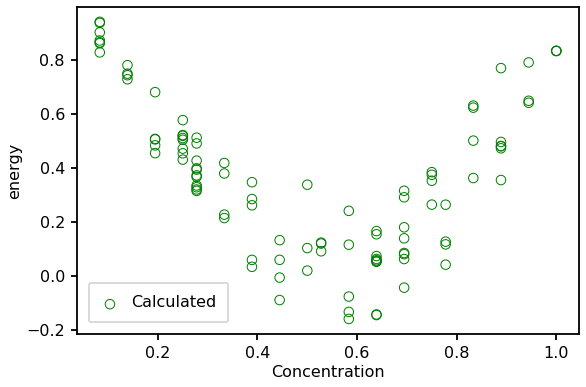

{'concentration': [0.8888888888888888,
  0.6388888888888888,
  0.2777777777777778,
  0.2777777777777778,
  0.25,
  0.6944444444444444,
  0.6944444444444444,
  0.6944444444444444,
  0.9444444444444444,
  0.2777777777777778,
  0.7777777777777778,
  0.5833333333333334,
  0.3333333333333333,
  0.08333333333333333,
  0.19444444444444445,
  0.08333333333333333,
  0.6944444444444444,
  0.7777777777777778,
  0.8333333333333334,
  0.1388888888888889,
  0.5,
  0.6388888888888888,
  0.5,
  1.0,
  0.5277777777777778,
  0.7777777777777778,
  0.25,
  0.5833333333333334,
  0.2777777777777778,
  0.75,
  0.3333333333333333,
  0.1388888888888889,
  0.19444444444444445,
  0.4444444444444444,
  0.5833333333333334,
  0.1388888888888889,
  0.75,
  0.25,
  0.5833333333333334,
  0.3888888888888889,
  0.8888888888888888,
  0.1388888888888889,
  0.25,
  0.08333333333333333,
  0.8333333333333334,
  0.2777777777777778,
  0.25,
  0.6388888888888888,
  0.3888888888888889,
  0.5833333333333334,
  0.8888888888888888,

In [18]:
# step 4 we need to compare and plot the energy of the 100 structures with the energy of structure with 0 %Zn and 100*Zn
refs = StructuresSet(platt)
refs.add_structure(scell.gen_random({0:[0]})) # Pristine
refs.add_structure(scell.gen_random({0:[len(scell)]})) # Full Cu substitution

calculation_function(refs, "energyref", calculator=EMT2(), folder_prefix="AuPd_error") 

refs.read_property_values("energyref") # retrieves property values (here energy) from .dat files of the same name
ref_en = refs.get_property_values(property_name="energyref")
print(ref_en)

plot_property_vs_concentration(sset, site_type=0, property_name="energy",refs=ref_en,scale=0.6)



In [ ]:
# step 5 we need to create a pool of cluster that would be applied later our supercell

r = 3.939 #/(2**(1/2))*2 # distance in Angstrom
from clusterx.clusters.clusters_pool import ClustersPool
cpool = ClustersPool(platt, npoints=[0,1,2,3], radii=[0, -1,-1,-1], super_cell=scell) #here we are asking for pool of clusters with a substitution npoints with specific radii, more we add points and increase the sistances more it will be accurate however it will take more times to generate
print(len(cpool)," clusters were generated.")

In [ ]:
cpool.serialize(db_name="cpool_CuPd.json")
#juview(cpool.get_cpool_atoms())
#view(cpool.get_cpool_atoms())

In [ ]:
#step 5: Building the CE model, here we will use the g linear regression method (other methods are available too) from our pool and supercell that we have build in step 2 and 4

from clusterx.model import ModelBuilder
mb = ModelBuilder(selector_type="linreg",selector_opts={'clusters_sets':'size'},estimator_type="skl_LinearRegression",estimator_opts={"fit_intercept":False})
cemodel1 = mb.build(sset, cpool, "total_energy_emt") #Build CE model using the training data set
cpool_opt1 = mb.get_opt_cpool()
cemodel1.report_errors(sset)
cpool_opt1.display_info(ecis=cemodel1.get_ecis())
cpool_opt1.write_clusters_db(db_name="cpool_opt.json") #CV?

In [ ]:
# plotting the results
from clusterx.visualization import plot_optimization_vs_number_of_clusters
from clusterx.visualization import plot_predictions_vs_target
plot_optimization_vs_number_of_clusters(mb.get_selector(),scale=0.5)
plot_predictions_vs_target(sset,cemodel1,"total_energy_emt",scale=0.5)
plot_property_vs_concentration(sset, site_type=0, property_name="total_energy_emt",cemodel=cemodel1,refs=ref_en,scale=0.5)

In [ ]:
# more accurate set
#mb = ModelBuilder(selector_type="linreg",selector_opts={'clusters_sets':'size+combinations','nclmax':2,'set0':[1,3.939]},estimator_type="skl_LinearRegression",estimator_opts={"fit_intercept":True})
#cemodel3 = mb.build(sset, cpool, "total_energy_emt") #Build CE model using the training data set
#cpool_opt3 = mb.get_opt_cpool()
#cemodel3.report_errors(sset)
#cpool_opt3.display_info(ecis=cemodel3.get_ecis())
#cpool_opt3.write_clusters_db(db_name="cpool_opt3.json")

In [ ]:
#plot_optimization_vs_number_of_clusters(mb.get_selector(),scale=0.5)
#plot_predictions_vs_target(sset,cemodel3,"total_energy_emt",scale=0.5)
#plot_property_vs_concentration(sset, site_type=2, property_name="total_energy_emt",cemodel=cemodel3,refs=ref_en,scale=0.5)

In [ ]:
#step 6: Monte Carlo simulations
scell.get_sublattice_types(pretty_print=True)
sites_dict = scell.get_nsites_per_type()
for key in sites_dict.keys():
    print("Number of atoms in sublattice "+str(key)+":", sites_dict[key])

In [ ]:
nsites = len(scell.get_substitutional_atoms())
print(nsites)

In [ ]:
from clusterx.model import Model
cemodelE = Model(json_db_filepath ="sset2.json") # unable to import the file, what are we missing here
nsubs = {0:[4]}
kb = float(8.6173303*10**(-5)) # Boltzmann constant in eV/K
temp = 300 # Temperature in K

# Initialization of a MonteCarlo object
from clusterx.thermodynamics.monte_carlo import MonteCarlo
mc = MonteCarlo(cemodelE,
                scell,
                ensemble = "canonical",
                nsubs = nsubs,
                predict_swap = False)

#print(mc)
# Execution of a Metropolis Monte-Carlo sampling
traj = mc.metropolis(no_of_sampling_steps = 1000,
                     temperature = 800,
                     boltzmann_constant = kb,
                     scale_factor = [1/(1.0*nsites)])
'''

nsubs = {0:[4]}
kb = float(8.6173303*10**(-5)) # Boltzmann constant in eV/K
temp = 300 # Temperature in K

# Initialization of a MonteCarlo object
from clusterx.thermodynamics.monte_carlo import MonteCarlo
mc = MonteCarlo(cemodelE, \
                scell, \
                ensemble = "canonical", \
                nsubs = nsubs, \
                predict_swap = True)

# Execution of a Metropolis Monte-Carlo sampling
traj = mc.metropolis(no_of_sampling_steps = 1000, \
                     temperature = 800, \
                     boltzmann_constant = kb, \
                     scale_factor = [1/(1.0*nsites)])

In [ ]:
# questions to be asked
#1- is how is EMT2 working on Zn while normally EMT is not available for Zn atoms
#2-I belive we can install it on supercomputer, dos it work on more than 1 nodes, could socket be used,
#3-how far we can go with the npoints and distances for 4x4x7 
#3-what are CV-RMSE and training-RMSE, what is supposed to be more stabe
#4-where are located the predicted, calculated and most stable structures, where can I see them
#5-why in the more accurate CE model we have to redefine clusters_sets':'size+combinations','nclmax':2,'set0':[1,3.939], aren't these defined in the cpool, is that not enough,
#6-How to apply MC on the model we create,
#7-could I make it for all the compositions in a loop, 